# Learning Machines: Information Theory

## Code Preamble

In [37]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
import math
import numpy as np
import pandas as pd
import random
import seaborn as sns

from collections import Counter
from matplotlib import pyplot as plt

In [39]:
import sys
sys.path.append('../py')

from plots import (
    plot_zipf_dist, 
    compare_distributions_in_plot,
    plot_bernoulli,
    plot_discrete_distribution,
    plot_entropy
)

sns.set_style("ticks")

In [40]:
import warnings

warnings.filterwarnings('ignore')

## Resources

### Textbooks

- JR Pierce (1980). [*An Introduction to Information Theory – Symbols, Signals and Noise*](http://libgen.rs/book/index.php?md5=B7FA722640006DC4F64D4447FBC051E9). Second Revised Ed. Dover.
- TM Cover & JA Thomas  (2006) [*Elements of Information Theory*](http://libgen.rs/book/index.php?md5=F84D706DD712F25317DF40949026F072). Hoboken, N. J.: John Wiley & Sons. 
- KP Murphy (2021) [*Probabilistic Machine Learning: An Introduction*](https://probml.github.io/pml-book/book1.html). MIT Press

### Historical

- S Kullback S & RA Leibler (1951) [On Information and Sufficiency](https://projecteuclid.org/journals/annals-of-mathematical-statistics/volume-22/issue-1/On-Information-and-Sufficiency/10.1214/aoms/1177729694.full). *The Annals of Mathematical Statistics* 22(1):
79–86.
- Claude Shannon (1945) [*A Mathematical Theory of Cryptography - Case 10878*](https://www.iacr.org/museum/shannon/shannon45.pdf).
- Claude Shannon (1948a) [A Mathematical Theory of Communication](https://ieeexplore.ieee.org/document/6773024). The Bell System Technical Journal 27(3): 379–423.
- Claude Shannon (1948b) [A Mathematical Theory of Communication](https://onlinelibrary.wiley.com/doi/10.1002/j.1538-7305.1948.tb01338.x). The Bell System Technical Journal 27(4): 623–656.
- Claude Shannon & Warren Weaver (1963): [*The Mathematical Theory of Communication*](https://monoskop.org/images/b/be/Shannon_Claude_E_Weaver_Warren_The_Mathematical_Theory_of_Communication_1963.pdf). Illinois University Press.

## Premise: Language As Distribution

> A language is considered for cryptographic purposes to be a stochastic process which produces a discrete sequence of symbols in accordance with some systems of probabilities. Associated with a language there is a certain parameter $D$ which we call the redundancy of the language. $D$ measures, in a sense, how much a text in the language can be reduced in length without losing any information. As a simple example, if each word in a text is repeated a reduction of 50 per cent is immediately possible. Further reductions may be possible due to the statistical structure of the language, the high frequencies of certain letters or words, etc. The redundancy is of considerable importance in the study of secrecy systems. - Claude Shannon (1945, p. 2)

### Let's Unpack That!

- Language consists of discrete symbols
- These symbols are generated by a system of probabilities
- This system is not entirely random or "uniform", it has *structure* or ***redundancy***
- Consequently: "The redundancy is of considerable importance in the study of secrecy systems"

### What We'll Learn Today

- We'll revisit the idea of language as distribution
- We'll get a broad overview of probability distributions in general
    - Uniform, Bernoulli, Binomial, Normal
- Bits for counts
    - Aside: What is the logarithm?
- Bits for probabilities
- Information entropy
- Relative entropy and redundancy
- Kullback-Leibler Divergence
- Cross Entropy

### Why?

- There would be ***no* machine learning *without* information theory**
- Most models you will ever use hinge on **cross-entropy** loss
    - A way to measure the difference between *observed* and *expected* behaviour
    - Used to optimize a very large number of machine learning models
- These concepts are often considered hard
    - **My take:** Because they are taught poorly and hastily!
    - If we start from fundamentals, we can build an intuitive understanding of them
- Understand how machine learning models perceive the world!

### Zipf's Law

- Already in 1932, the linguist George Zipf had observed that word frequency is inversely proportional to work rank
- In other words: There's a statistical regularity to how frequent words are in text
- Let's take an example using Lewis Carroll's "Alice in Wonderland"

In [41]:
import nltk

from nltk.corpus import gutenberg
from nltk.tokenize import RegexpTokenizer
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [42]:
def tokens_from_gutenberg_text(txt_name):
    sents = gutenberg.sents(txt_name)
    words = [word for sent in sents for word in sent]
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(" ".join(words).lower())
    return tokens

In [43]:
alice_tokens = tokens_from_gutenberg_text('carroll-alice.txt')
alice_tokens[:10]

['alice',
 's',
 'adventures',
 'in',
 'wonderland',
 'by',
 'lewis',
 'carroll',
 '1865',
 'chapter']

In [44]:
alice_counts = Counter(alice_tokens)
alice_counts.most_common(10)

[('the', 1642),
 ('and', 872),
 ('to', 729),
 ('a', 632),
 ('it', 595),
 ('she', 553),
 ('i', 543),
 ('of', 514),
 ('said', 462),
 ('you', 411)]

In [45]:
def get_probs_from_counter(counts):
    sum_ = sum(counts.values())
    probs = Counter()
    for token in counts:
        probs[token] = np.float32(np.format_float_positional(counts[token] / sum_))
    return probs

In [46]:
alice_probs = get_probs_from_counter(alice_counts)
alice_probs.most_common(10)

[('the', 0.06006731),
 ('and', 0.031899326),
 ('to', 0.02666813),
 ('a', 0.023119695),
 ('it', 0.021766169),
 ('she', 0.020229734),
 ('i', 0.019863917),
 ('of', 0.018803043),
 ('said', 0.01690079),
 ('you', 0.015035119)]

In [47]:
def zipf_to_uniform(top_probs, n):
    return Counter({key: 0.5 for key in dict(top_probs[:n])})

alice_uniform = zipf_to_uniform(alice_probs.most_common(), 10)
alice_uniform

Counter({'the': 0.5,
         'and': 0.5,
         'to': 0.5,
         'a': 0.5,
         'it': 0.5,
         'she': 0.5,
         'i': 0.5,
         'of': 0.5,
         'said': 0.5,
         'you': 0.5})

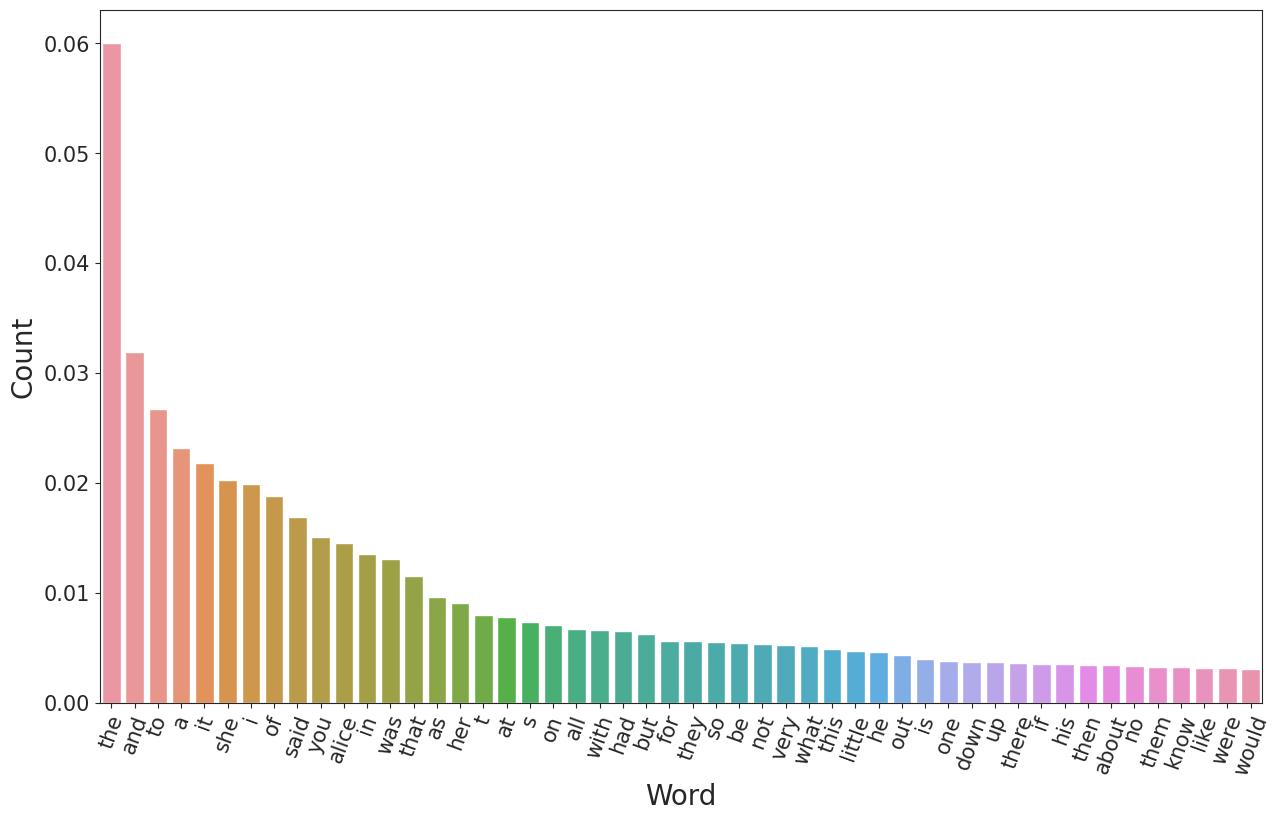

In [48]:
plot_zipf_dist(alice_probs, 'bar')

We could also plot the language using a line. This will be useful later when we want to compare distributions:

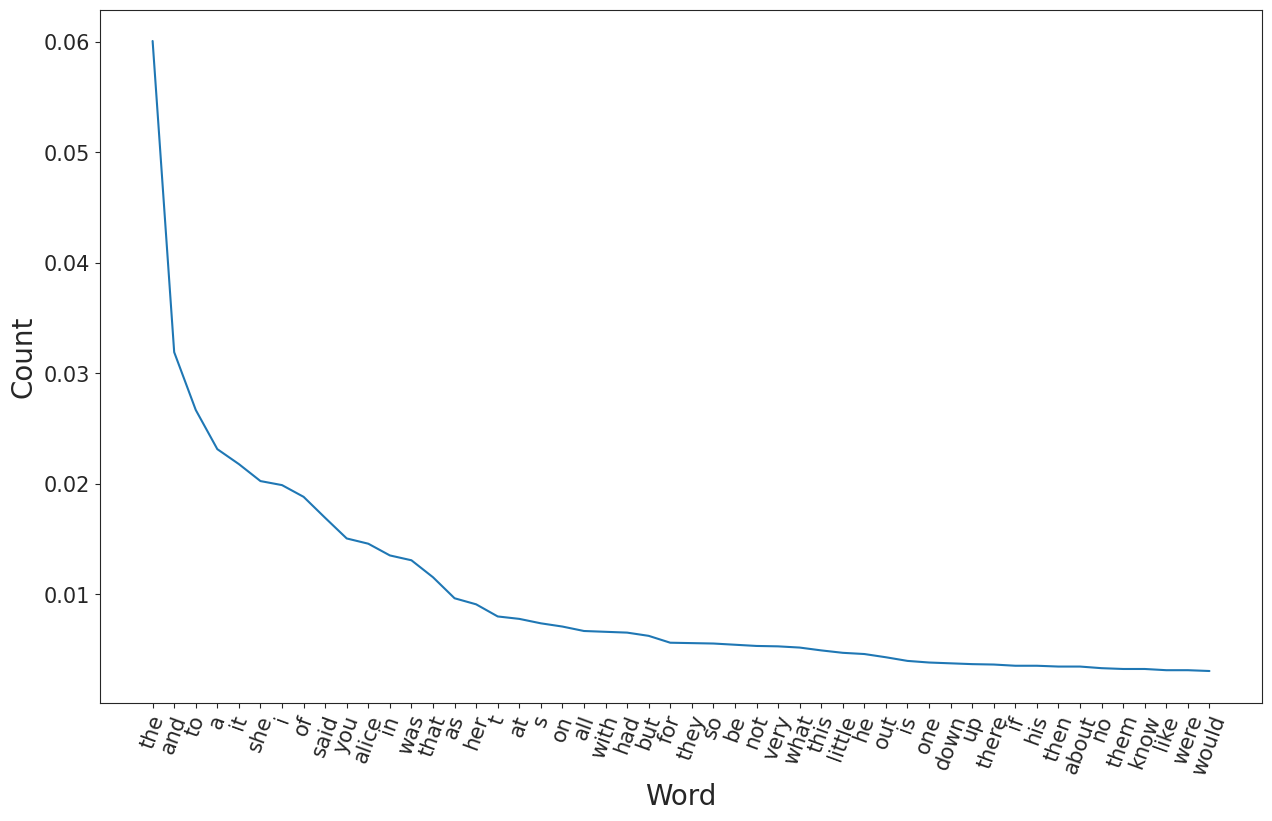

In [49]:
plot_zipf_dist(alice_probs, 'line')

### The Uniform Distribution

- What if we instead plot the uniform probabilities?
- We get what is known as the "uniform distribution"

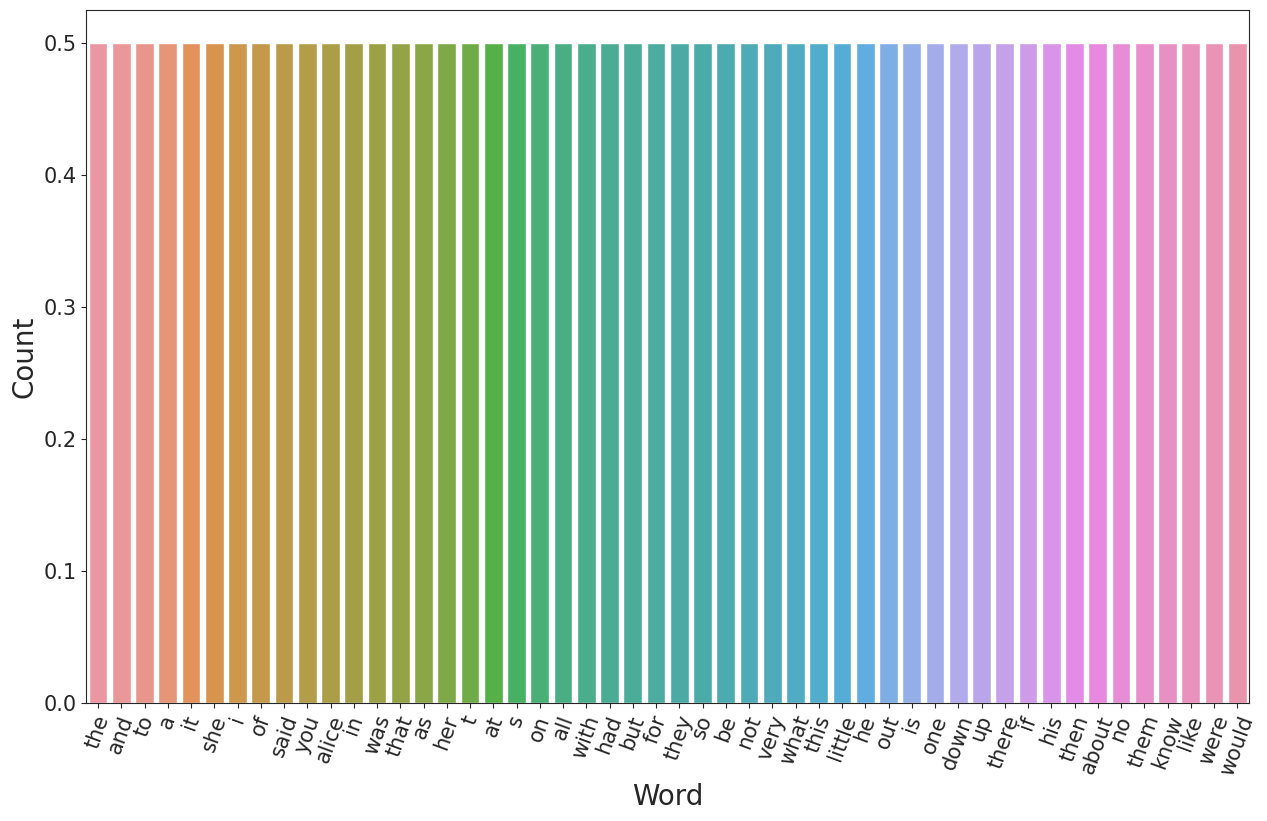

In [50]:
plot_zipf_dist(zipf_to_uniform(alice_probs.most_common(), 50), 'bar')

### The Uniform Distribution

- Now there is no structure or redundancy
- There are words, but could we even distinguish their "meaning" if language behaved like this?
- Probably not!

### Aside: The Limits of Zipf's Law

- However, as we've already seen something like Zif's law won't generate what we would recognize as "language"
- We will need more complex approximations, which is where neural nets come in the picture
- Nonetheless: We can use Zipf's Law to get an understanding of how we want to proceed to compare *distributions*

In [51]:
def zipf_unigram_lm(probs, n):
    output = ''
    for i in range(0,n):
        predicted_word = np.random.choice(list(probs.keys()), 
                                          1, 
                                          p=list(probs.values()))[0]
        output += predicted_word + ' '
    return output.strip()

zipf_unigram_lm(alice_probs, 10)

'shall had lobster in just a and sentence a say'

## What Are Distributions?

- Before we move onward to information, let's take a moment to really understand distributions
- Why? Because, as we will see, **information** measures the *properties of distributions*

### Generating Distributions with Numpy

- We want to see how some function behavs across the x-axis
    - We need to generated a bunch of x-values
    - Our x-axis measures the probabilitiy of heads for different distributions
    - So it goes from 0 to 1

In [52]:
p_heads_interval_10 = np.linspace(0, 1, 10)
p_heads_interval_10

array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ])

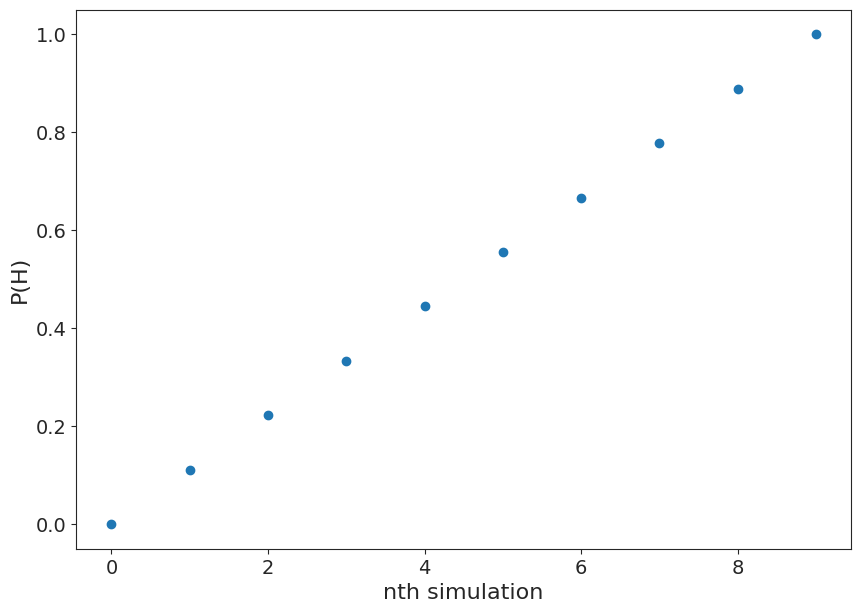

In [53]:
plt.scatter(list(range(0, len(p_heads_interval_10))), p_heads_interval_10)
plt.xlabel("nth simulation", fontsize=16)
plt.ylabel("P(H)", fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.show()

- Now we can actually generate a distribution
- For that, let's go back to our old friend the **coin toss**
- We let the probability of heads increase in small increments from 0 to 100
- That gives us a list of different values for $P(H)$
- Now we can get a similar sized but *inverse* list of $P(T)$ by just taking $1 - P(H)$

**PROMPT:** Generate ```p_heads``` using ```linspace``` and then use ```p_heads``` to create ```p_tails```.

In [54]:
# YOUR CODE HERE
p_heads = np.linspace(0, 1, 100)
p_tails = 1 - p_heads


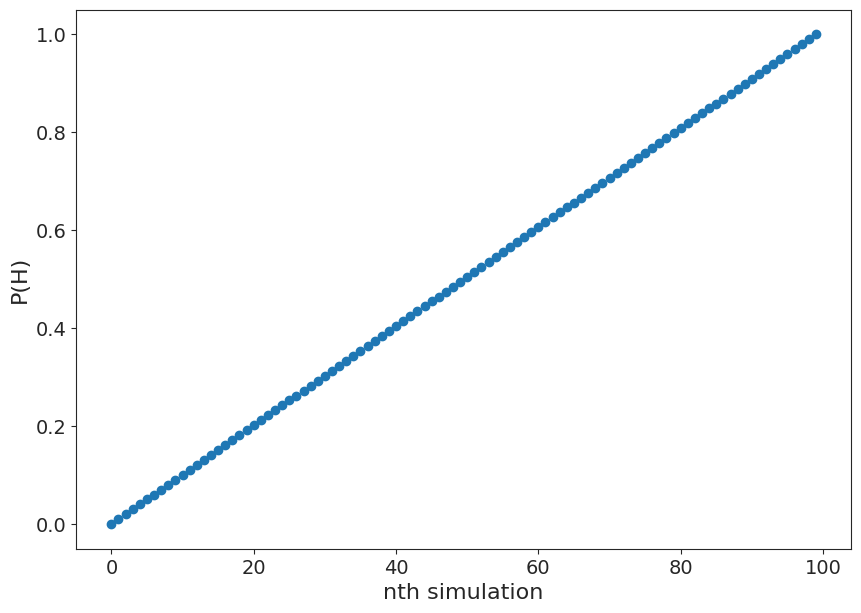

In [55]:
plt.scatter(list(range(0, len(p_heads))), p_heads)
plt.xlabel("nth simulation", fontsize=16)
plt.ylabel("P(H)", fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.show()

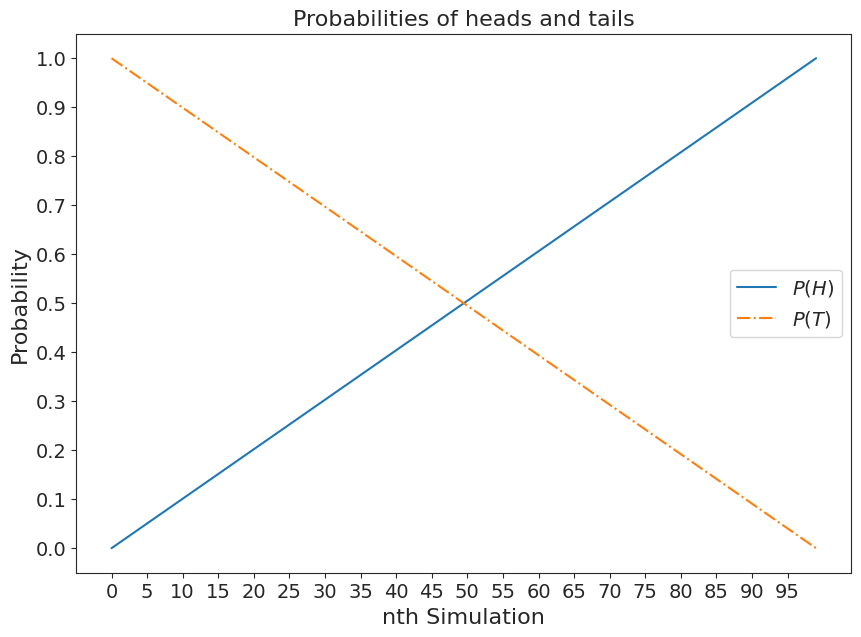

In [56]:
compare_distributions_in_plot(list(range(0, 100)),
                              p_heads, 
                              p_tails,
                              r'$P(H)$',
                              r'$P(T)$',
                              "nth Simulation",
                              "Probability",
                              "Probabilities of heads and tails")

- As expected, $P(H)$ decreases as $P(T)$ increases and vice versa

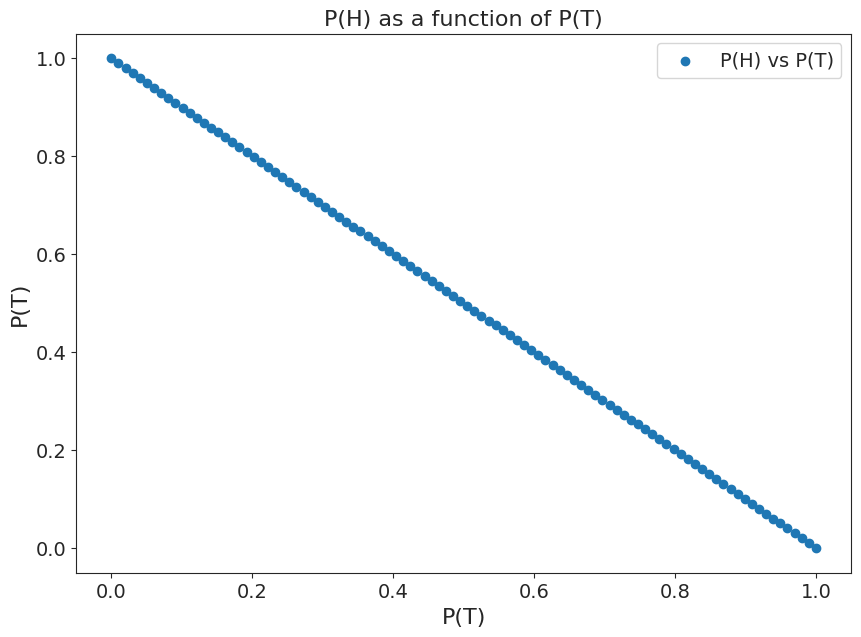

In [57]:
plt.rcParams["figure.figsize"] = (10,7)
plt.scatter(p_tails, p_heads, label = "P(H) vs P(T)")
plt.xlabel("P(T)", fontsize=16)
plt.ylabel("P(T)", fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.legend(fontsize=14)
plt.title("P(H) as a function of P(T)", fontsize=16)
plt.show()

## Distributions = Models

- Distributions are also **models**
    - Assumptions about how our data is distributed
    - Once we have a distribution, we can "draw" or "simulate" from it, i.e use it to generate *new* data
- This is what a language model does when it predicts!
- Let's look at some well known distributions to clarify the point

### The Bernoulli Distribution

- What would we do instead of just looking at a single coin, wanted to do an experiment with 100 trials?
- What is our **model** here, i.e. what distribution do we assume our data is generated from?
    - This type of experiment with two outcomes simulates from the so called **Bernoulli distribution**
- Let's take a look!

- First, we want to define a function to toss our coin. Afterall, we'll be tossing it 100 times!

**PROMPT:** ```random.random()``` generates a random value between 0 and 1. Use this to build a function that takes the value ```p```. ```p``` is the bias of the coin, i.e. 0.5 for a fair coin. The function should use ```random.random()``` to return the strings "heads" or "tails". <div>
**Hint:** Use ```if``` and ```else```. 

In [58]:
def coin_toss(p):
    # YOUR CODE HERE
    val = random.random()
    if val <= p:
        return 'heads'
    else:
        return 'tails'

In [59]:
coin_toss(0.5)

'heads'

- Now, let's repeat that $n$ times, where $n$ is the number of trials in our experiment (in our case 100)
- For each trial, we keep a tally, heads or tails

**PROMPT:** Write a function ```count_outcomes```. It should contain a loop that calls ```coin_toss``` to generate ```n``` coin tosses at some ```p_heads```. Give ```n``` and ```p_heads``` as inputs to the function and return a ```Counter```. 

In [60]:
def count_outcomes(n=100, p_heads=0.5):
    # YOUR CODE HERE
    outcomes = [coin_toss(p_heads) for i in range(n)]
    return Counter(outcomes)

- We set the size of $n$ but also the probability of heads
- We will keep using an unbiased coin

In [61]:
n_trials = 100
p = 0.5
count_outcomes(n=n_trials, p_heads=p)['heads']

53

- Now we can simulate and plot an outcome from our distribution

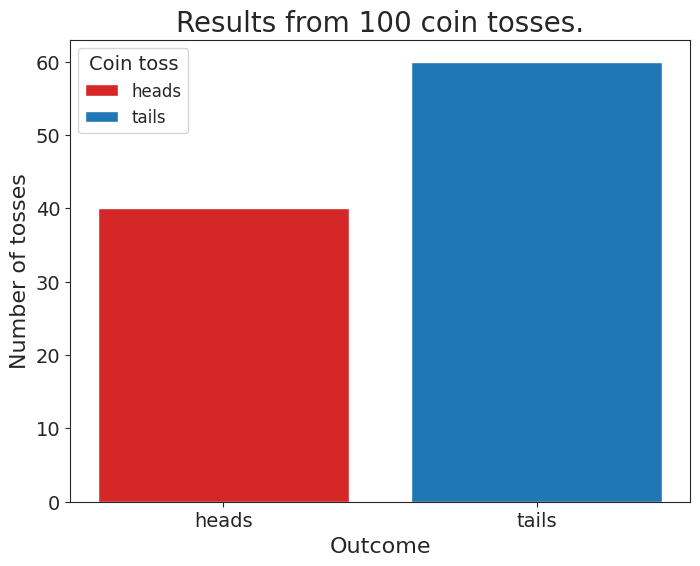

In [62]:
heads = count_outcomes(n=n_trials, p_heads=0.5)['heads']
tails = n_trials - heads
plot_bernoulli([heads, tails])

- Let's try that with a biased coin, $P(H) = 0.7$

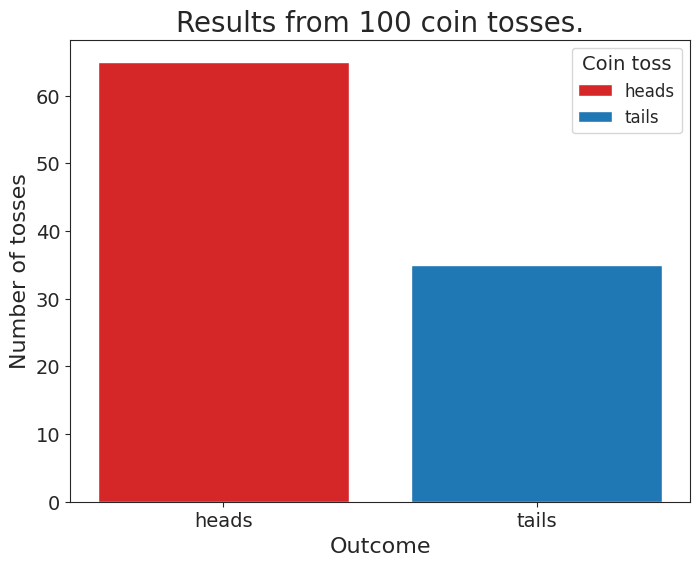

In [63]:
heads = count_outcomes(n=n_trials, p_heads=0.7)['heads']
tails = n_trials - heads
plot_bernoulli([heads, tails])

### The Binomial Distribution

- However, as we've seen our simulation is still quite unstable.
- What if we now instead repeated that experiment 10 times?
- So: 10 experiments, each with 100 coin tosses
- This type of experiment will draw from the **binomial distribution**

In [64]:
def simulate(ns=100, n=100, p=0.5):
    sims = []
    for i in range(0,ns):
        outcomes = count_outcomes(n, p)
        sims.append(outcomes)
    return [(s['heads'], s['tails']) for s in sims]

Now we have to add the number of simulations, in addition to the number of trials.

In [65]:
n_sims = 1000
n_trials = 10
sims = simulate(ns=n_sims, n=n_trials, p=0.2)

n_heads = [s[0] for s in sims]
n_tails = [s[1] for s in sims]

sims_df = pd.DataFrame(data={'heads':n_heads, 
                             'tails':n_tails})

We have one row for each trial, and one column for each outcome.

In [66]:
print(sims_df.shape)
sims_df.head()

(1000, 2)


,heads,tails
0,2,8
1,3,7
2,0,10
3,2,8
4,2,8


When we plot it, we notice it's slightly skewed. This is because our probability is skewed.

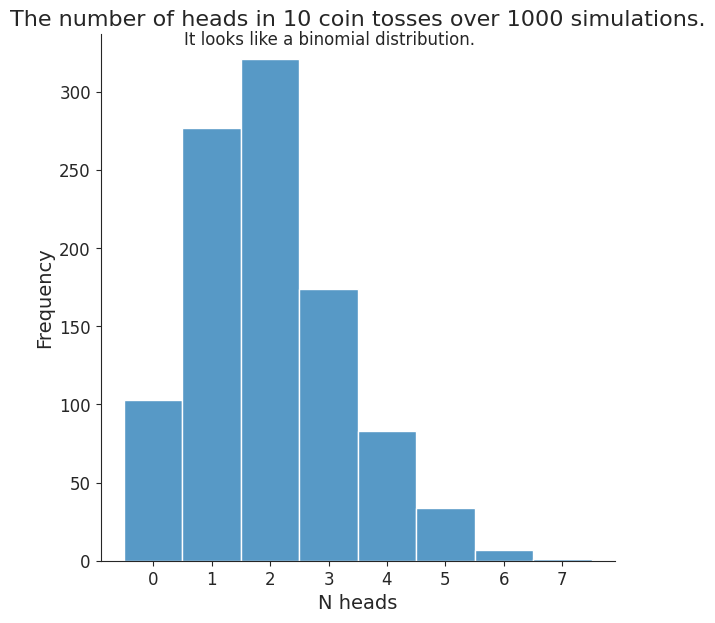

In [67]:
plot_discrete_distribution(sims_df, 
                           'heads', 
                           f'The number of heads in {n_trials} coin tosses over {n_sims} simulations.',
                           'It looks like a binomial distribution.',
                           'N heads',
                           'Frequency')

### The Normal Distribution & Central Limit Theorem

- A key result in statistics is if we have enough repetitions, many distributions start to look like the **normal distribution**
- This is known as the **Central Limit Theorem**

In [68]:
n_sims = 1000
n_tosses = 1000

sims = simulate(ns=n_sims, n=n_tosses, p=0.2)

n_heads = [s[0] for s in sims]
n_tails = [s[1] for s in sims]

sims_df = pd.DataFrame(data={'heads':n_heads, 
                             'tails':n_tails})

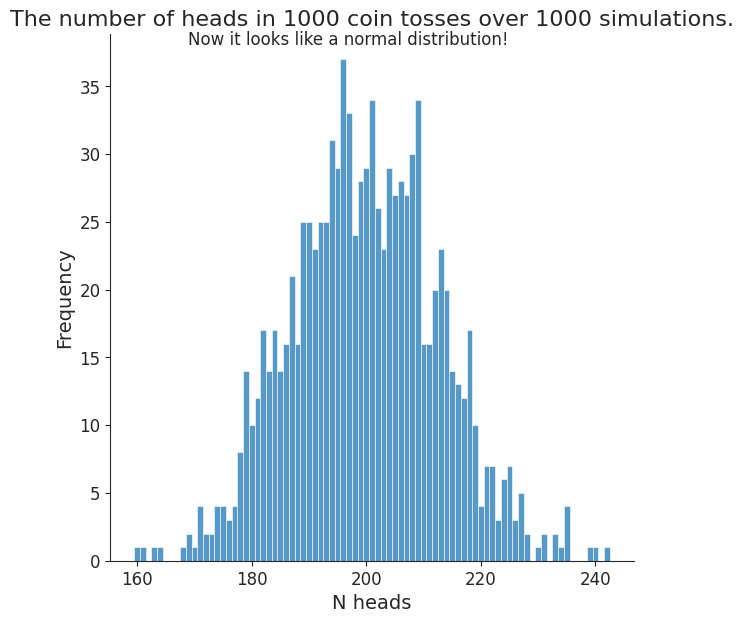

In [69]:
plot_discrete_distribution(sims_df, 
                           'heads', 
                           f'The number of heads in {n_tosses} coin tosses over {n_sims} simulations.',
                           'Now it looks like a normal distribution!',
                           'N heads',
                           'Frequency')

## Representing Distributions with Bits

- Okay, now we've established some key things:
    - We know what a distribution is
    - We know that Shannon and other pioneers of cybernetics thought of language as a stochastic process 
        - Ergo: Language was a distribution for them 
    - If we know some of the statistical regularities or the "redundancies" of this distribution we can work on problems like cryptography and machine translation.
- However: In order to do anything practical with this information, our distributions of interested have to be somehow **represented**

- Let's revisit the image of the noisy channel. When an information source decides to send a signal, it has to be somehow encoded
- Basing his ideas on innovations in "Boolean algebra", Shannon decided that the most intuitive way to represent anything was the most simple one: as "yes" or "no", 0 or 1.
- A poll in the Bell Labs coffee room established that this unit should be known as a "bit" of information

<center>
<div>
<img src="../img/shannon_general_communication_system_diagram.png" width="80%"
     caption="test"/><p>
    <figcaption>Shannon's diagram for a "general communication system".</figcaption>
</div>
</center>


- Let's follow the structure in Shannon's seminal papers and work up our intuition on bits from the most simple possible example to more complex ones
    - The coin toss returns!

**PROMPT:** If we want to represent a coin toss as bits, how do we proceed?

In [70]:
def print_simple_bit_table(outcome, bits):
    n_bits = [len(b) for b in bits]
    
    return pd.DataFrame(
        {'outcomes':outcome, 
         'bits':bits, 
         'n_bits':n_bits}).style.hide()

In [71]:
print_simple_bit_table(['heads', 'tails'], ['0', '1'])

outcomes,bits,n_bits
heads,0,1
tails,1,1


In [72]:
probs = [0.5, 0.5]
n_bits = [1, 1]

**PROMPT:** Let's move up. If we want to represent the sample space of two coin tosses in bits, how do we do it?

**PROMPT:** What is the sample space?

$A = \{HH, HT, TT, TH \}$

In [73]:
two_toss_combinations = ['HH', 'HT', 'TT', 'TH']
two_bit_combinations = ['00', '01', '10', '11']

print_simple_bit_table(two_toss_combinations, two_bit_combinations)

outcomes,bits,n_bits
HH,00,2
HT,01,2
TT,10,2
TH,11,2


**PROMPT:** If someone did this experiment, how many questions would we need *on average* to find out what the outcome was?

<!--- TYPE QUESTIONS HERE -->

Of course we could get lucky by asking just one question. Say, for example, the outcome was $HH$. If we ask "was it heads and heads", we would've needed only one question. But then we would've been lucky. *On average* we need two questions. This was the big innovation from Shannon. A ***bit is the number of yes-no questions we need to ask in order to know an outcome in an experiment***. This is why Gregory Bateson called a bit "the difference that makes a difference".

Before we go on to formalize this discovery mathematically, let's build up some more intuition.

Let's consider an experiment with three trials or tosses. Typing that out is annoying, so we'll use a helper function for it.

In [74]:
from itertools import product

def produce_N_combinations(items, N):
    return [''.join(x) for x in product(items, repeat = N)]

**PROMPT:** How big is the sample space of eight trials? You can use ```produce_N_compitations``` to find out.

In [75]:
# YOUR CODE HERE
three_toss_combinations = produce_N_combinations(['T', 'H'], 3)

**PROMPT:** How would we encode that in bits? Use ```produce_N_combinations``` again, if you want.

In [76]:
# YOUR CODE HERE
def encode(coin_side):
    if coin_side == 'H':
        return '0'
    else:
        return '1'
        
three_bit_combinations = [''.join([encode(side) for side in result]) for result in three_toss_combinations]
three_bit_combinations

['111', '110', '101', '100', '011', '010', '001', '000']

In [77]:
print_simple_bit_table(three_toss_combinations, 
                       three_bit_combinations)

outcomes,bits,n_bits
TTT,111,3
TTH,110,3
THT,101,3
THH,100,3
HTT,011,3
HTH,010,3
HHT,001,3
HHH,000,3


**PROMPT:** How many questions do we need now?

<!---- Type questions here ---->

**PROMPT:** Do you notice some sort of connection between how we build our outcomes and the number of bits we need to describe the distribution?

Yes, there is indeed a connection. And that's good, because all this counting can get tiresome... 

To know how many options we have to choose among, we can use a simple formula. If $S$ is the number of symbols we can choose from (i.e. 2, because we choose between $H$ and $T$) and $n$ is the number of combinations of those (3 in the above example), then the number of basic outcomes $E$ is:
    
$E = S^n$

Let's try it out:

In [78]:
S = 2
n = 3

In [79]:
E = np.power(S, n)
E

8

**PROMPT:** How many bits will we need to represent these options?

If we already know $E$, we can find out how many bits we need by taking the logarithm of $E$, because the logarithm is simply the inverse of a power:

In [80]:
# Count number of bits here using ```np2.log()```.


In fact, we can count the number of bits we need directly from $n$ and $S$:

In [81]:
n*np.log2(S)

3.0

This is also how Ralph Hartley, an engineer at Bell Labs, defined information in a paper in 1928. For him information was just:

$$
n \cdot \log S
$$

But this isn't the definition of that history settled on, and *only* applies to uniform distributions. Before we move on, let's take a little detour.

## Aside: What Does the Logarithm Do?

We use $log_2$ because it assumes $S=2$. 
- If we use some other logarithm, it's no longer a bit!
- Using a logarithm of the natural number $e$ would produce "nats"

- The logarithm to the base 2 of a number is the power to which 2 must be raised to equal the number
- We can express the same thing mathematically:

$$
2^{\log_2 x} = x\\
$$

- With our three tosses of heads and tails:

$$
\log_2 8 = 3 \\
2^{\log_2 8} = 8 \\
2^3 = 8 
$$

Two must be raised to $3$ to give us 8.

**PROMPT:** What are the logarithms of the following numbers: 1, 2, 4, 8, 16, 32, 64?

<!---- Your notes here ---->

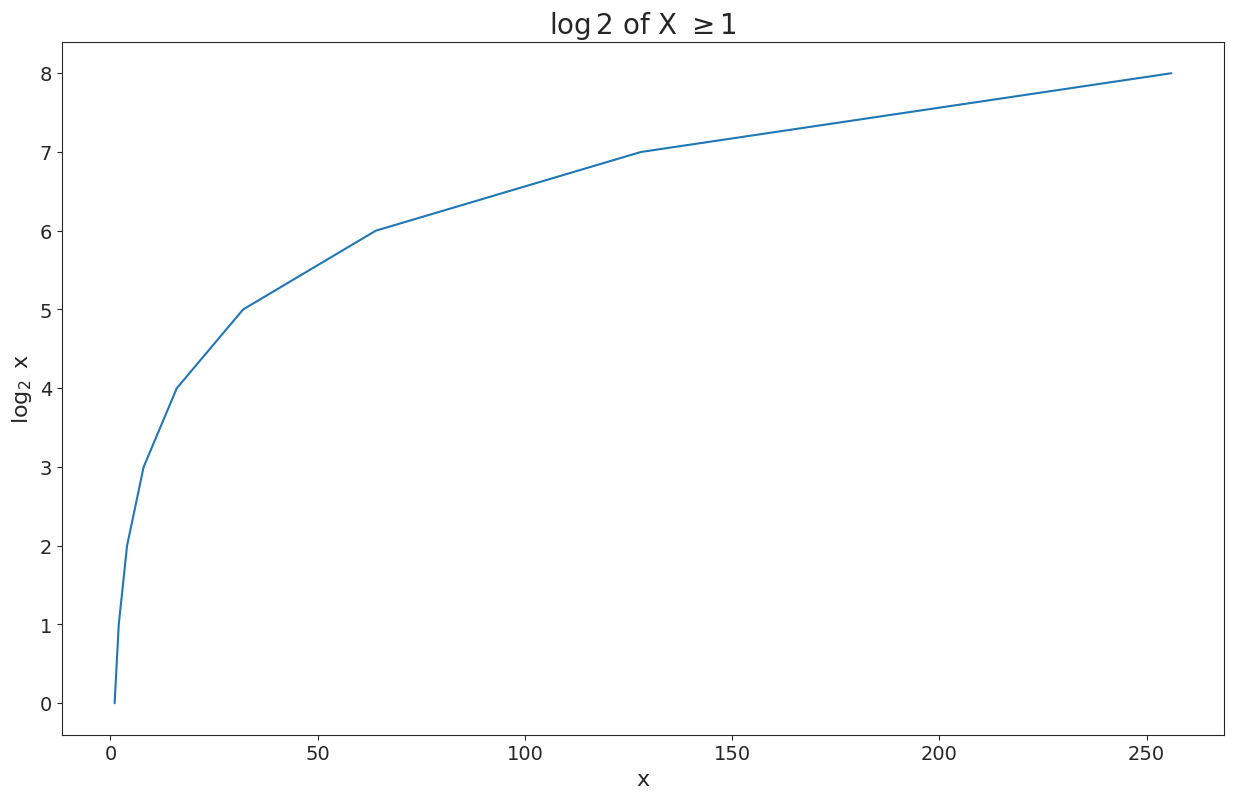

In [82]:
fig, ax = plt.subplots(figsize=(15,9))
plt.plot([1,2,4,8,16,32,64, 128, 256], np.log2([1,2,4,8,16,32,64, 128, 256]))
plt.xlabel("x", fontsize=16); plt.ylabel(r"$\log_2$ x", fontsize=16); plt.tick_params(axis='both', which='major', labelsize=14)
plt.title(r"$\log2$ of X $\geq 1$", fontsize=20)
plt.show()

### Bits for Probabilities

So far we have worked with *counts*, but we started out asking how we could encode *probabilities*. How could we make that leap? An interesting property with the logarithm, is that taking the log of a fraction gives us the same result as taking the log of the denominator *but negative*. So

$$
\log_2 2 = 1
$$

And:

$$
\log_2\frac{1}{2} = - 1
$$

This means that counting logs for a uniform distribution where all events are equally probable is just like working with counts, but negative!

**PROMPT:** What are the logarithms of the following numbers: $\frac{1}{2}, \frac{1}{4}, \frac{1}{8}, \frac{1}{16}, \frac{1}{32}, \frac{1}{64}$

<!---- Your notes here ---->

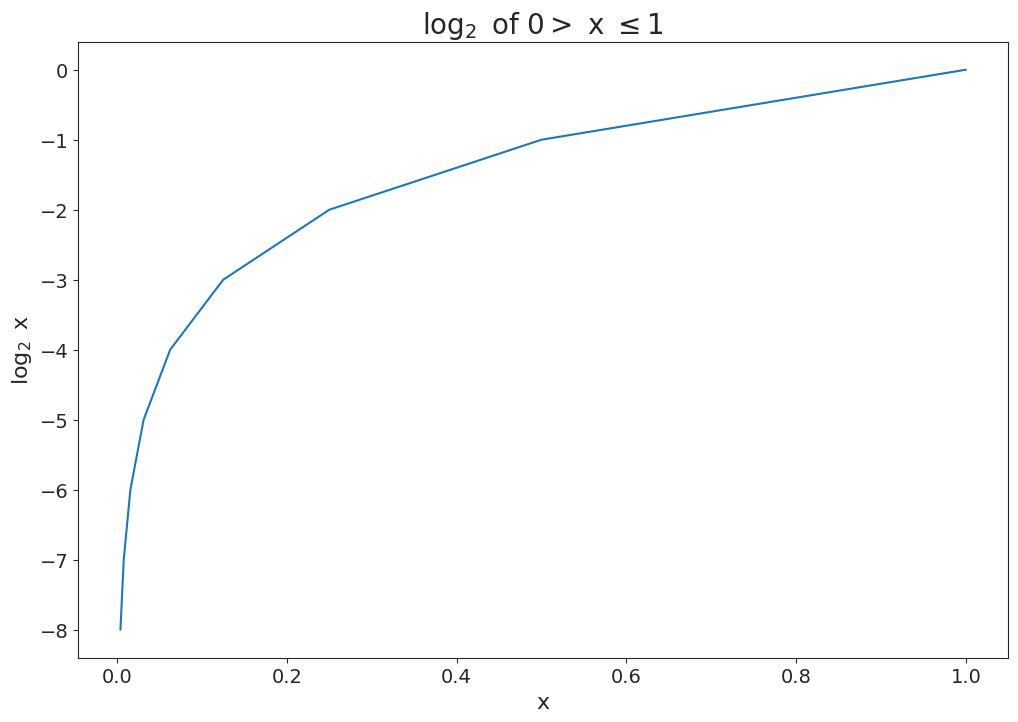

In [83]:
fig, ax = plt.subplots(figsize=(12,8))
plt.plot([1/256, 1/128, 1/64, 1/32, 1/16, 1/8, 1/4,1/2, 1], 
         np.log2([1/256, 1/128, 1/64, 1/32, 1/16, 1/8, 1/4,1/2, 1]))
plt.xlabel("x", fontsize=16); plt.ylabel(r"$\log_2$ x", fontsize=16); plt.tick_params(axis='both', which='major', labelsize=14)
plt.title(r"$\log_2$ of $0 >$ x $\leq 1$", fontsize=20)
plt.show()

## From Bits to Information Entropy

We are now ready to understand the mathematical concept of **information entropy**. 

To do so, let's return to the unbiased coin, once again. We already know we need two bits to encode it. BUt what if we wanted to calculate this value just from knowing the probabilities:

$$
P(H) = \frac{1}{2} \;\;\;
P(T) = \frac{1}{2}
$$

If we take the log of these, we get:
    
$$
\log_2\frac{1}{2} + \log_2\frac{1}{2} = \\
-1 + (-1) = \\ 
-2
$$

But that's too much! And negative! We know the bits to encode a fair coin is one. What we need to do is to weigh each event in our distribution by it's probability to get not just a sum but a **"weighted sum"**. 
$$
\begin{equation*}
\left(\frac{1}{2}\times\log_2\frac{1}{2}\right) + \left(\frac{1}{2}\times\log_2\frac{1}{2}\right) = \\
\left(\frac{1}{2}\times(-1)\right) + \left(\frac{1}{2}\times(-1)\right) = \\
-\frac{1}{2} -\frac{1}{2} = \\
-1
\end{equation*}
$$



Better! But still negative. What we do is just reverse the sign of the equation, like this:
    
$$
\begin{equation*}
-1 \times \left[\left(\frac{1}{2}\times\log_2\frac{1}{2}\right) + \left(\frac{1}{2}\times\log_2\frac{1}{2}\right)\right] = \\
-1 \times \left[\left(\frac{1}{2}\times(-1)\right) + \left(\frac{1}{2}\times(-1)\right)\right] = \\ 
-1 \times \left[-\frac{1}{2} -\frac{1}{2}\right] = \\
-1 \times (-1) = \\
1
\end{equation*}
$$


We can actually use this to take a stab at a first definition of **information entropy**. We will use the symbol $\mathbb{H}$. So let's imagine a distribution $X$ with two outcomes $x_1$ and $x_2$ and let's for simplicity's sake say they have probabilities $p_1$ and $p_2$. Then, the information entropy is:

$$
\mathbb{H}(X) = -(p_1 \log_2 p_1 + p_2 \log_2 p_2))
$$

And we can actually generalize this to a case with any number of outcomes and with any probability values, like this:
    
$$
\begin{equation}
  \mathbb{H}(X) = -\overbrace{\sum_{i=1}^N P(x_i)}^\text{Weighted sum} \underbrace{\log_2 P(x_i)}_\text{Bits}
\end{equation}
$$

Let's unpack again.

1) First, the intimidating symbol $\sum_{i=1}^N$ just states that we sum over all the probabilities in our distribution, with $N$ outcomes $x_i$, each of them indexed with $i$. It's like going over all the values in a list of length $N$ in a for-loop and adding them, just like the symbol $\prod$ did for multiplication. Because we are summing probabilities, what we get is a weighted sum, just like we wanted.

2) Second, we calculate the bits required to encode each outcome. This we already went over above.

3) Third, we take the negative value of the whole thing, because the logarithms of fractions are negative (and probabilities are always fractions, except at 0 and 1) and we want the actual bits, not a negative value.

4) The $(X)$ after $\mathbb{H}$ just says that we are going over an entire distribution. It's notation for "random variable", which for our purposes is synonymous with distribution. It's not necessary, but you will see that notation quite often when doing machine learning, so it's good to know it.

**PROMPT:** How would you code entropy if you were to use a for loop? **Hint:** You will need to use ```np.log2```

Great! Let's wrap that in a function. $\log_2 0$ is undefined, so we need to handle that separately.

In [84]:
# YOUR CODE HERE
def shannon_entropy(probs):
    h = 0
    for p in probs:
        if p == 0:
            h += 0
        else:
            h += p * np.log2(p)
    return -h

Let's now go over all these distributions and get the entropy for each of them. We'll need a list of distributions.

In [85]:
prob_distributions = list(zip(p_heads, p_tails))
prob_distributions[:2]


[(0.0, 1.0), (0.010101010101010102, 0.98989898989899)]

**PROMPT** Get the entropy for each distribution in ```prob_distributions```. Save the output as a ```list```. <div>
**Remember:** Each tuple in this list is a probability distribution.<div>
**Hint:** You can use list comprehensions

In [86]:
coin_entropies = [shannon_entropy(probs) for probs in prob_distributions]

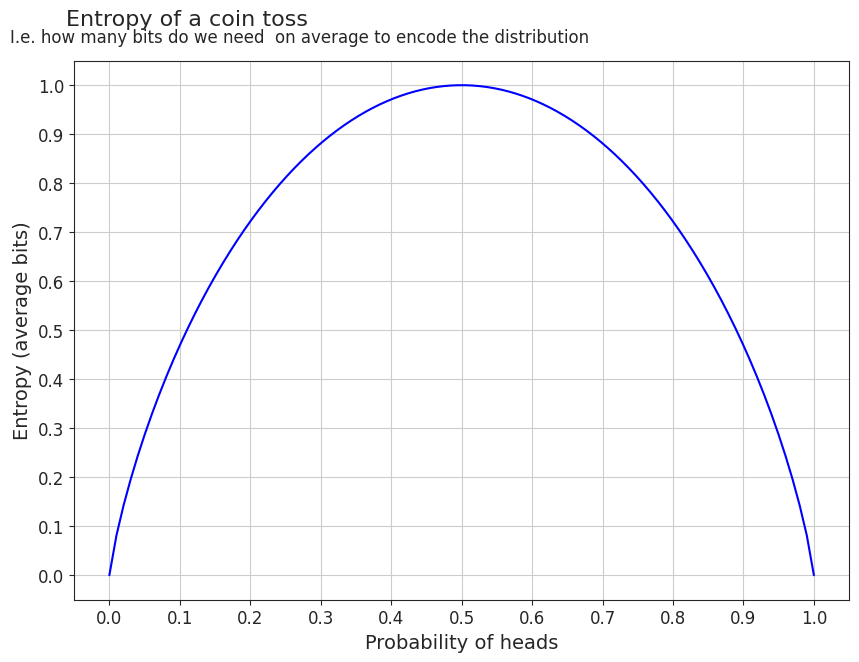

In [87]:
plot_entropy(coin_entropies)

We can also write our function in numpy, without the for-loop. It's a good exercise to do this, because for these types of functions people will rarely use for-loops.

**PROMPT:** Re-write the entropy function in ```numpy```. <br>
**Hints:** 
- It's one line of code for the entropy itself, but...
- ... if you want to handle the zeroes (you don't have to), you can do this:

In [88]:
p = np.array([0,1])
p = p[p > 0]
p

array([1])

In [92]:
def entropy_np(p):
    probs = np.array(list(p))
    probs = probs[probs > 0]
    entropy = -np.sum(probs * np.log2(probs))
    return entropy

Let's plot it to make sure it's the same as the for-loop version.

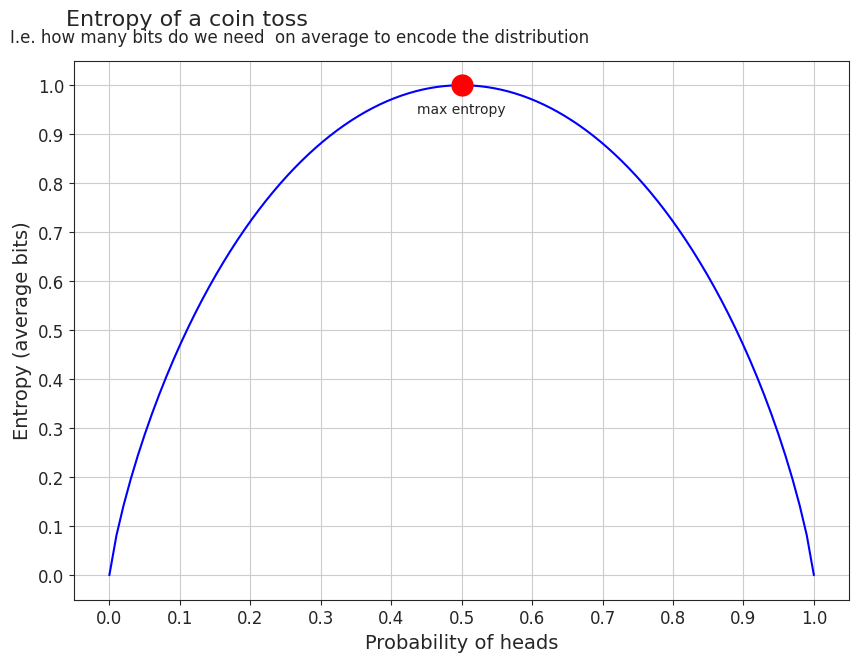

In [93]:
coin_entropies = [entropy_np(prob_dist) for prob_dist in prob_distributions]

plot_entropy(coin_entropies, True)

 And indeed it is! We've also added a red dot to highlight where the entropy as it's highest. 
 - It's the point where $P(H)=0.5$, i.e. where $P(T)$ is also equal to $0.5$. 
 - This is where the distribution is uniform. 
 - This is why Weaver and Shannon called this least informative distribution the **"maximum entropy" distribution**.

Why is entropy maximized where the distribution is uniform? 
- Because this is where there is no structure, no redundancy.
- All events are equally likely. 
- This hightlights Shannon's idea that information measures **suprise**. 
- When there is no structure, all events are equally surprising, so "average surprise" is maximized!

Entropy is *not* at it's highest where probability is at it's highest, because:

1) Probability measures the properties of *individual* events
2) Information entropy measures the properties of *entire distributions*

## Bits for (a very simple) Language

Let's now imagine an artificial language with only four letters, all equally probable. The letters are our unknown $x_i$ variable, and we index them with $i$ like this:

$$
x_1 = A, \; x_2 = B, \; x_3 = C, \; x_4 = D
$$

They also have corresponding probabilities, so that 

$$
p(x_1) = 0.25, \; p(x_2) = 0.25, \; p(x_3) = 0.25, \; p(x_4) = 0.25
$$

In [94]:
language = ['A', 'B', 'C', 'D']
uniform_probs = [0.25]*4
uniform_probs
#lang_probs = [0.5, 0.25, 0.125, 0.125]

[0.25, 0.25, 0.25, 0.25]

Let's plot the language as a distribution

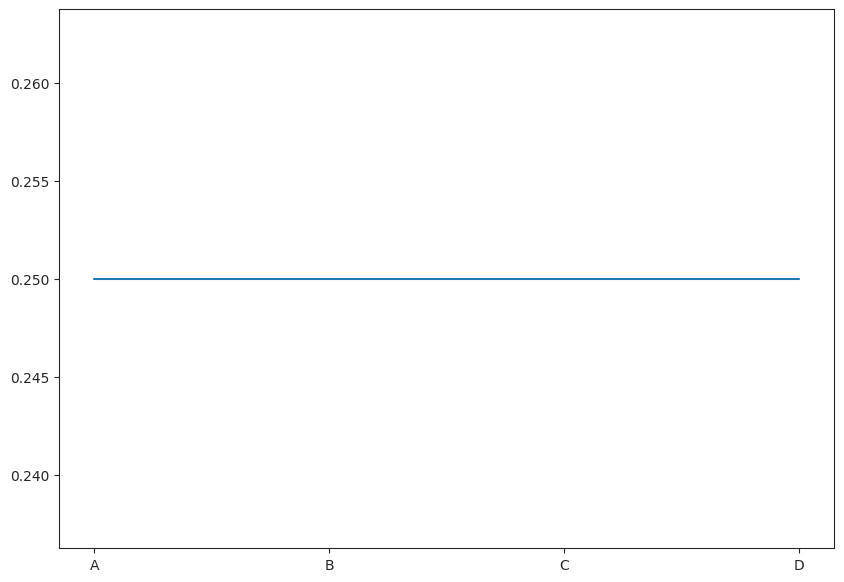

In [95]:
plt.plot(uniform_probs)
plt.xticks([0, 1, 2, 3], labels=language)
plt.show()

Our language has a uniform distribution, so the line is flat. We've seen this type of event before: 
- When we were tossing our fair coin two times, we had four possible outcomes, just like now. 
- The average bits we needed to encode those outcomes were $2$. 

Let's see if that's true now as well:

In [96]:
entropy_np(uniform_probs)

2.0

No surprises here. Or, from Shannon's perspective, **only surprises**! 
- Each outcome requires two bits to encode. 
- To clarify, we can re-write our code for the bit table to include the probability of the events.

In [97]:
def print_bit_table(outcome, bits, probs):
    n_bits = [len(b) for b in bits]
    
    return pd.DataFrame(
        {'outcomes':outcome, 
         'bits':bits, 
         'n_bits':n_bits,
         'prob':np.round(probs, 3).astype(str)
        }).style.hide()

In [98]:
uniform_bits = ['00', '01', '10', '11']
print_bit_table(language, uniform_bits, uniform_probs)

outcomes,bits,n_bits,prob
A,00,2,0.25
B,01,2,0.25
C,10,2,0.25
D,11,2,0.25


But what if our language instead had the following probabilities:
    
$$
p(x_1) = 0.5 \\ p(x_2) = 0.25 \\ p(x_3) = 0.125 \\ p(x_4) = 0.125
$$

In [99]:
language = ['A', 'B', 'C', 'D']
lang_probs = [0.5, 0.25, 0.125, 0.125]
sum(lang_probs)

1.0

Let's plot that again.

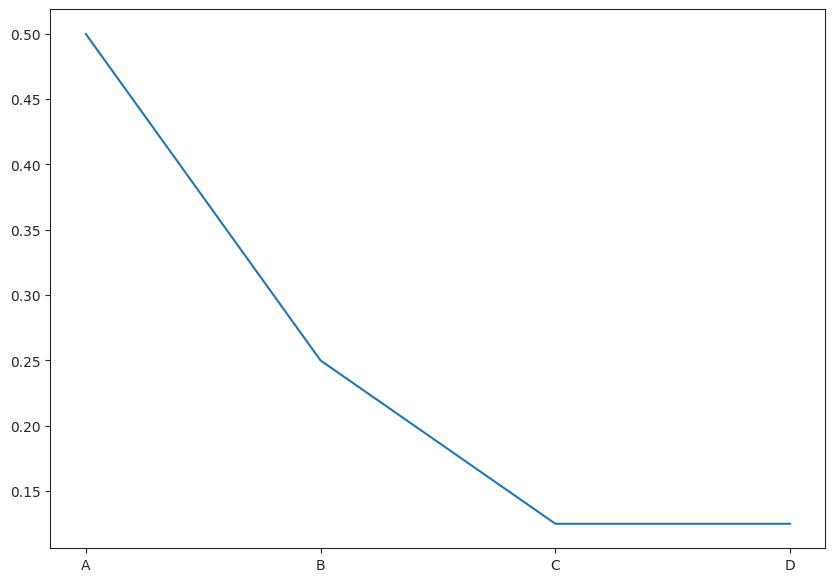

In [100]:
plt.plot(lang_probs)
plt.xticks([0, 1, 2, 3], labels=language)
plt.show()

Looks familiar? Well, we've just created a language that seems to follow Zipf's Law. It's more simple than an actual language to make analysis easier, but the idea is the same:

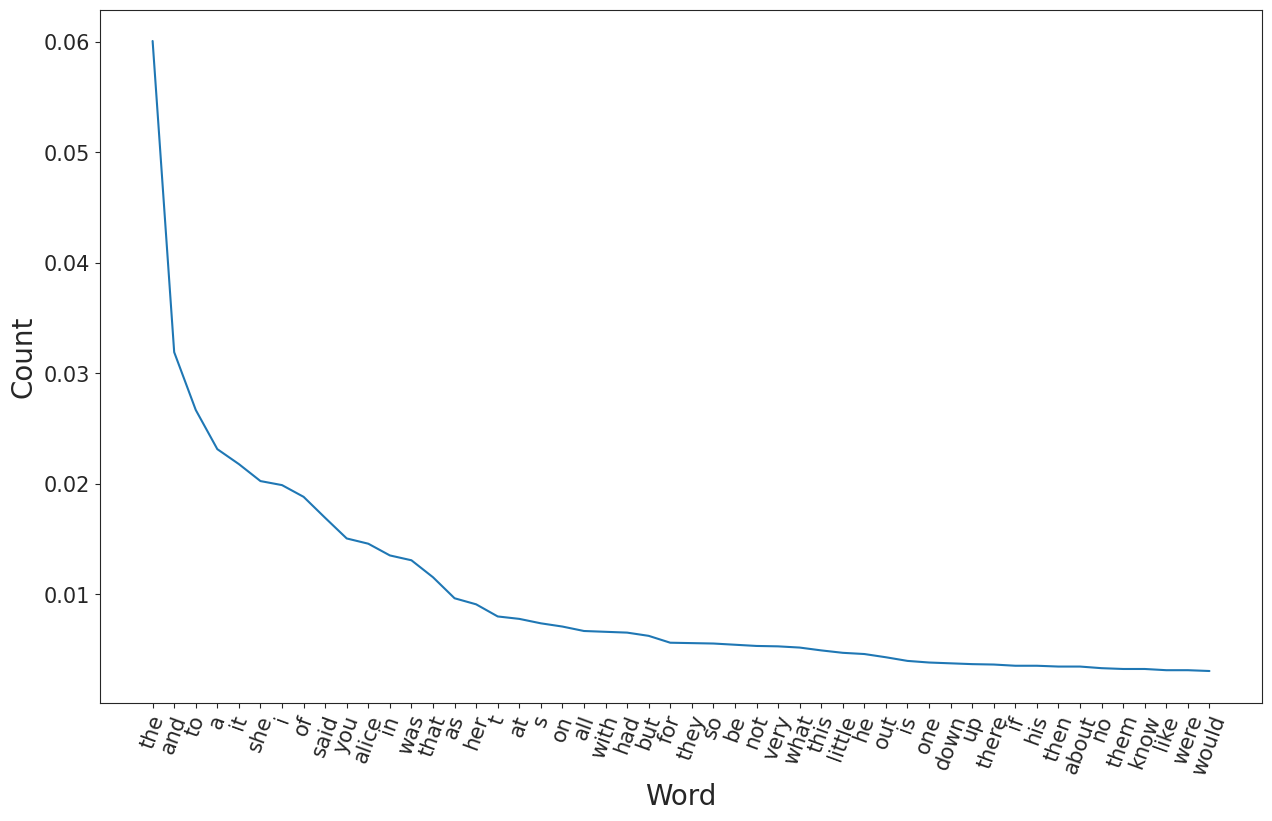

In [101]:
plot_zipf_dist(alice_probs, 'line')

If we now want to encode this language in bits, how do we go about it? Well, for starters we know how many bits we need on average. That knowledge is provided by our entropy function.

In [104]:
lang_entropy = entropy_np(lang_probs)
lang_entropy

1.75

But we know more than that, each outcome needs a number of bits that corresponds to it's probability:

$$
\text{bits for } A = -\log p(A) = -\log\frac{1}{2}=1 \\
\text{bits for } B = -\log p(B) =-\log\frac{1}{4}=2 \\
\text{bits for } C = -\log p(C) =-\log\frac{1}{8}=3 \\
\text{bits for } D = -\log p(D) =-\log\frac{1}{8}=3
$$

Does this work? Let's try!

**PROMPT:** Calculate how many bits we have on average, if we weigh each by their corresponding probability.

In [105]:
average_bits = # YOUR CODE HERE

SyntaxError: invalid syntax (1459399434.py, line 1)

It matches the entropy! Let's make that into a function.

In [106]:
def average_bits(probs, n_bits):
    return np.sum(np.multiply(probs, n_bits))

n_lang_bits = [1,2,3,3]
average_bits(lang_probs, n_lang_bits) == entropy_np(lang_probs)

True

If we output our bit table with these values, we see what such an encoding could look like.

PROMPT** Create the list ```lang_bits``` with four entries. Make these correspond to the bits each letter should have:

$$
A:1, \; B:2, \; C:3 \; D:3 
$$

In [108]:
lang_bits = ['0', '10', '110', '111']# YOUR CODE HERE
print_bit_table(language, lang_bits, lang_probs)

outcomes,bits,n_bits,prob
A,0,1,0.5
B,10,2,0.25
C,110,3,0.125
D,111,3,0.125


## Comparing Distributions: Relative Entropy & Redundancy

Let's reiterate what we've learned so far.

First, we've learned to calculate:

1. The bits to encode the outcomes of *one* distribution
2. The average bits for this encoding

Second, we know that:

1. The information entropy of *one* distribution consists of the weighted sum of bits.
2. Entropy measures surprise. The more uniform, the higher the entropy. An entirely uniform distribution is the "maximum entropy" distribution.

But what if we want to compare distributions? What if we want to somehow measure the entropy of their difference?

Let's start with two familiar examples. 
- We have our language with $A$, $B$, $C$ and $D$. 
- We know their probabilities. 
- We also know what it would look like if we assumed an uniform distribution for them. 

Let's now compare these two distributions.

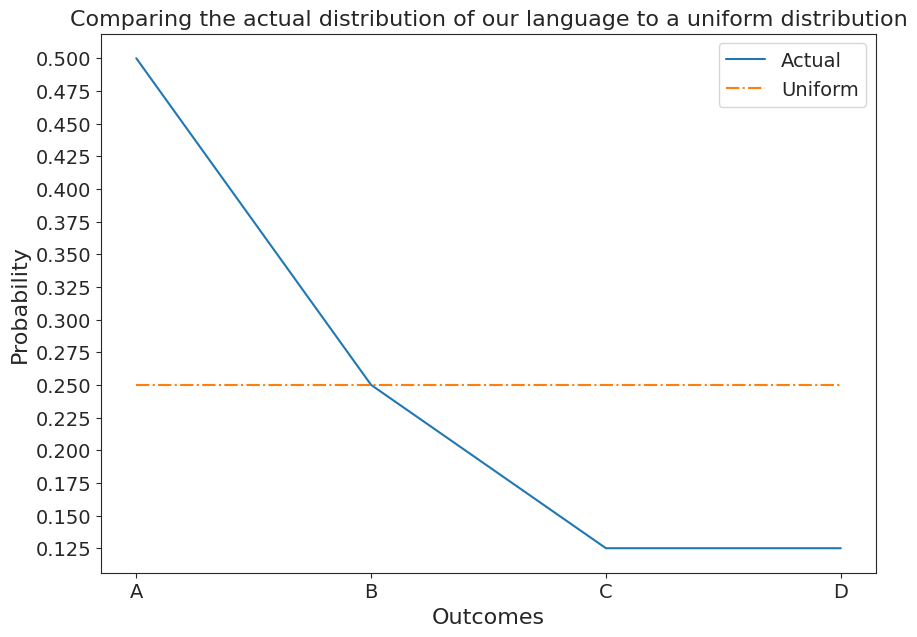

In [110]:
compare_distributions_in_plot(language, 
                              lang_probs, 
                              uniform_probs,
                              'Actual',
                              'Uniform',
                              'Outcomes',
                              'Probability',
                              'Comparing the actual distribution of our language to a uniform distribution')

One way we could compare them, is to just take their ratio. We will call this ratio **"relative entropy"**:

$$
\text{Relative entropy} = \frac{\text{Entropy of a distribution}}{\text{The max entropy of the same distribution}}
$$

**PROMPT:** Can you write that in Python for our example above? Wrap it in a function like this: ```def relative_entropy(true_ent, max_ent)```.

Recall the entropies of these two distributions:

In [111]:
uniform_entropy = entropy_np(uniform_probs)

In [112]:
lang_entropy = entropy_np(lang_probs)

In [113]:
def relative_entropy(true_ent, max_ent):
    return true_ent / max_ent

In [114]:
relative_entropy(lang_entropy, uniform_entropy)

0.875

Shannon introduces this concept in his work to describe the difference between the entropy of our source and a completely uniform version of the same source. In Shannon's (p. 56) own words:

> The ratio of the entropy of a source to the maximum value it could have while still restricted to the same symbols will be called its *relative entropy*. 

What does relative entropy capture then? Weaver gets into this question in his intro to Shannon's work:

> If the relative entropy of a certain source is, say .8, this roughly means that this source is, in its choice of symbols to form a message, about 80 per cent as free as it could possibly be with these same symbols. 

Shannon himself did a bunch of experiments to conclude that the redundancy of written English is about 50%. In his opinion:

> This means that when we write English half of what we write is determined by the structure of the language and half is chosen freely.

One way to better understand what relative entropy captures, is by looking at it's relationship to **redundancy**. Shannon defined **redundancy** in terms of relative entropy as:

$$
\text{Redundancy }= 1-\text{ Relative Entropy}
$$

Relative entropy tells us how much freedom we have and redundancy tells us how much we lack. The uniform distribution is total freedom: Everything is equally possible! Once we add structure, our choices become more constrained. According to Shannon, redundancy

> is the fraction of the structure of the message which is determined not by the free choice of the sender, but rather by the accepted statistical rules governing the use of the symbols in question.

There are some interesting philosophical implications here: Our use of language is just the actualization of the virtual space of possible outcomes, governed by statistical rules. A decisively posthuman vision of communication!

**PROMPT:** What is the redundancy of our artificial language?

In [115]:
1 - relative_entropy(lang_entropy, uniform_entropy)

0.125

While Shannon and Weaver limited their analysis of relative entropy to the ratio between the entropy of a source and its max entropy, the principle of calculating such ratios can be extended.

Let's now instead say that we are familiar with the language $A$, $B$, $C$ $D$, but we don't quite know what the probabilities for each outcome are. Based on our prior knowledge, we would guess it is something like this:

$$
p(A) = 0.625 \\ p(B) = 0.125 \\ p(C) = 0.125 \\ p(D) = 0.125
$$

In [117]:
assumed_probs = [0.625, 0.125, 0.125, 0.125]
sum(assumed_probs)

1.0

Comparing these visually, we see that it's an okay estimation.

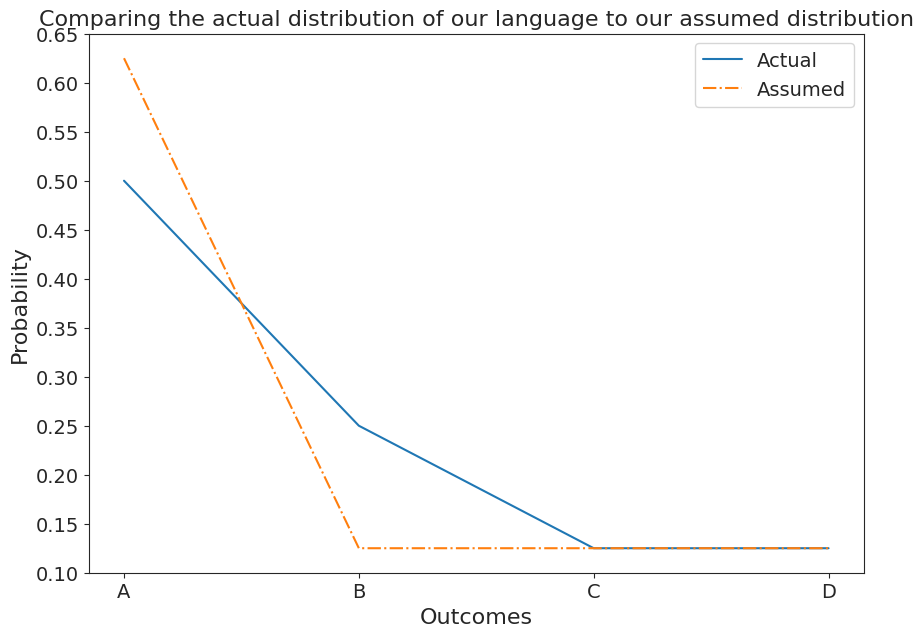

In [118]:
compare_distributions_in_plot(language, 
                              lang_probs, 
                              assumed_probs,
                              'Actual',
                              'Assumed',
                              'Outcomes',
                              'Probability',
                              'Comparing the actual distribution of our language to our assumed distribution')

The entropy for our estimate is:

In [119]:
assumed_entropy = entropy_np(assumed_probs)
assumed_entropy

1.5487949406953985

And compared to you actual entropy, we see that our assumed language is actually more structured. The high probability given to $A$ makes it more deterministic:

In [120]:
relative_entropy(lang_entropy, assumed_entropy)

1.1299107157557358

Let's stop for a moment to recall what we set out to do: We wanted to find a metric to measure the difference between different probability distributions. And now we've done?!

Well yes, kind of. But there's a problem. 

**PROMPT:** What might isse be with using relative entropy to compare distributions?

<!---- YOUR NOTES HERE ----->

Imagine our language from above, but with inverse probabilities. So:

$$
p(A) = 0.125 \\ p(B) = 0.125 \\ p(C) = 0.25 \\ p(D) = 0.5
$$

In [121]:
inverse_probs = lang_probs.copy()
inverse_probs.reverse()
inverse_probs

[0.125, 0.125, 0.25, 0.5]

Now we see that while our distributions have shaped that mirror each other, our estimate would surely produce terrible predictions!

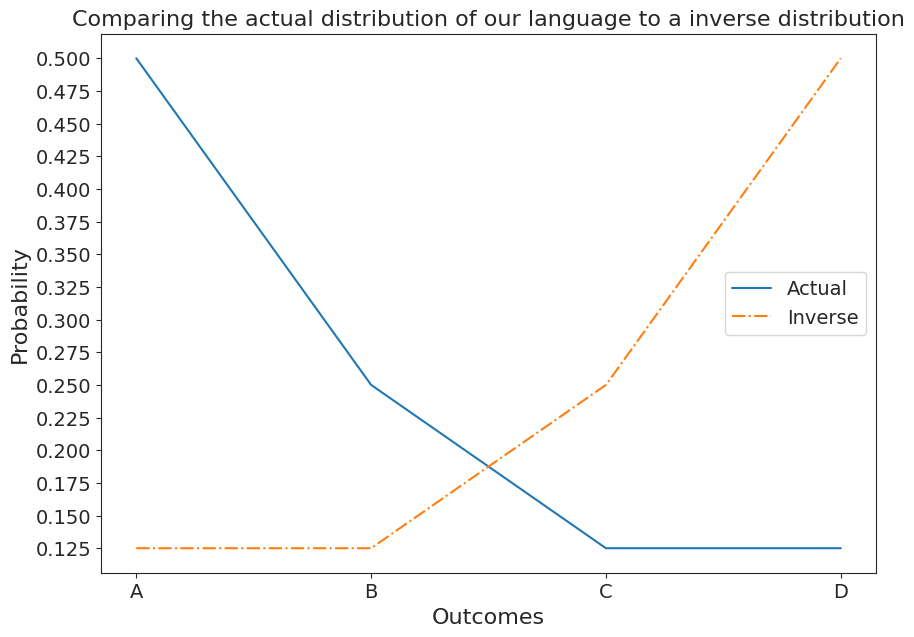

In [122]:
compare_distributions_in_plot(language, 
                              lang_probs, 
                              inverse_probs,
                              'Actual',
                              'Inverse',
                              'Outcomes',
                              'Probability',
                              'Comparing the actual distribution of our language to a inverse distribution')

**PROMPT:** What is the relative entropy between these two distributions?

In [90]:
# YOUR CODE HERE

1.75

Relative entropy says nothing about the actual shape of the distribution, it just tells what it's mean is. We will need sharper tools to actually compare distributions. But we will still use entropy!

## Comparing Distributions: The Kullback-Leibler Divergence

Today, no one uses relative entropy or redundancy in machine learning, at least not in the sense that they were defined by Shannon. Instead, people use metrics that were further developed from the idea of relative entropy by other people who built on Shannon's work.

One particularly important measure like this is the Kullback-Leibler Divergence or $\mathbb{KL}$. 
- It was developed by mathemtaicians Solomon Kullback and Richard Leibler in a 1951 paper. 
- While they didn't name it after themselves, other people since then have started using this name. 
- It's from the $\mathbb{KL}$ divergence that cross-entrop, the perhaps most commonly used tool for comparing distributions in ML, is derived.

Let's start with intuition again.

What if for every outcome $x_i$ in our distribution, we compared the number of bits we need to encode that outcome?

**PROMPT:** Can you code such a for-loop in Python?

In [125]:
# YOUR CODE HERE
entropy_diff = 0
kl = 0
for p in lang_probs:
    kl += p * (np.log2(p) - np.log2(0.25))
print(kl)

def kld(p, q):
    return np.sum(p * np.log2(p / q))


0.25


What? We actually need in total one bit more to encode our structured language than we need for the uniform distribution. And indeed, this is true, we see it from our bit tables:

In [126]:
print_bit_table(language, lang_bits, lang_probs)

outcomes,bits,n_bits,prob
A,0,1,0.5
B,10,2,0.25
C,110,3,0.125
D,111,3,0.125


In [127]:
print_bit_table(language, uniform_bits, uniform_probs)

outcomes,bits,n_bits,prob
A,00,2,0.25
B,01,2,0.25
C,10,2,0.25
D,11,2,0.25


Our structured language requires 9 bits to encode, our uniform distribution only takes 8:

In [128]:
print(sum(n_lang_bits))
print(4*2)

9
8


But entropy isn't about sums, it's about **weighted sums**, also known as **"expected value"** or, simply, **"mean"**.

So if we rewrite our loop, but now weigh every difference. What should we weigh it by? 
- Well, how about the probabilities of the actual distribution we are interested in? 
- Weighing the loop with the probabilities of our language, we get:

In [129]:
entropy_diff = 0

for p in lang_probs:
    entropy_diff += p*(np.log2(p) - np.log2(0.25))
entropy_diff

0.25

What we now get is the distance of the uniform distribution from the vantage point of our the probabilities of our artificial language. And this is the $\mathbb{KL}$ divergence! That's all there is to it. Let's write it in numpy and try it out.

**PROMPT:** Write the $\mathbb{KL}$ divergence in ```numpy```.

**Hint:** Here you have it as a loop:

In [130]:
def kl_divergence_loop(p, q):
    kld = 0
    for idx, p in enumerate(lang_probs):
        kld += p*(np.log2(p) - np.log2(q[idx]))
    return kld

In [131]:
def kl_divergence(p, q):
    kld = np.sum(p * np.log2(p / q))
    return kld

def kld(p, q):
    return np.sum(p * np.log2(p / q))

Nice! Let's try it out:

Our uniform distribution is on average 0.25 bits away from our actual distribution.

In [132]:
kl_divergence(np.array(lang_probs), np.array(uniform_probs))

0.25

Why is this true? Because, as we saw above, their total distance is $1$, so with four outcomes the average distance is $\frac{1}{4} = 0.25$.

Our estimate for the language is already a lot closer:

In [102]:
kl_divergence(np.array(lang_probs), np.array(assumed_probs))

0.08903595255631885

Then, if we compare our language to itself, the distance is $0$:

In [103]:
kl_divergence(np.array(lang_probs), np.array(lang_probs))

0.0

This means that we know exactly what distribution $P$ generated the data and the difference in bits needed to encode the distributions is zero. In other words, 

> it means that we can correctly predict the probabilities of all possible future events, and thus we have learned to predict the future as well as an ’oracle’ that has access to the true distribution P (Murphy 2021, 243).

Finally, how does the $\mathbb{KL}$ divergence do on our inverse distribution?

In [104]:
kl_divergence(np.array(lang_probs), np.array(inverse_probs))

0.875

Quite well, it turns out! Whereas relative entropy was unable to distinguish them, $\mathbb{KL}$ divergence shows that they are further away from each other than any other distributions we compared.

If you felt like getting here was surprisingly easy, take a look at how $\mathbb{KL}$ divergence is derived in a typical textbook:

$$
{\begin{equation}
    \begin{aligned}
        \mathbb{KL}(p \vert\vert q) &= \overbrace{E\bigg[\log_2 p(x_i) - \log_2 q(x_i)\bigg]}^\color{red}{\text{Expected surpise of p when encoding with q}} \\
         &= \underset{i=1}{\sum}p(x_i) \cdot \bigg[\log_2 p(x_i) - \log_2 q(x_i)\bigg] \\
         &= \underset{i=1}{\sum} p(x_i) \log_2 \frac{p(x_i)}{q(x_i)} \\
         &= \underset{i=1}{\sum} p(x_i)\log_2 p(x_i) - \underset{i=1}{\sum} p(x_i)\log_2 q(x_i) \\
         &= \underbrace{-\mathbb{H}(p)}_\text{Negentropy of p} + \underbrace{\mathbb{H}(p,q)}_\text{Cross-entropy between p and q}
     \end{aligned}
\end{equation}}
$$

Looks hard? Well, sure. But mostly because we aren't familiar with the notation and the associated rules of different symbols. Building up the intuition slowly and in code, it's hopefully more clear :)

Now we can move on to our last part: **cross-entropy**. This function is the last terms of the $\mathbb{KL}$ divergence above and probably the most commonly used optimization function in neural networks today.

## Comparing Distributions: Cross-Entropy

With cross-entropy, we take a step back and go to the original definition of entropy. 
- What if we encoded our artificial language with bits corresponding to some other language. 
- For example: What if we used the bits for the uniform distribution to encode the artificial language? 
    - How many bits would we then need on average. 

Let's say the distributions $P$ and $Q$ have the same outcomes $x_i$, but with different probabilities $p(x_i)$ and $q(x_i)$. Then, in terms of our equation for information, it would look like this:

$$
\begin{equation}
  \mathbb{H}(P,Q) = -\overbrace{\sum_{i=1}^N p(x_i)}^\text{Weighted sum for P} \underbrace{\log_2 q(x_i)}_\text{Bits for Q}
\end{equation}
$$

We can modify our $\mathbb{KL}$ divergence loop accordingly.

**PROMPT:** Write cross-entropy with a for-loop or in ```numpy```. <div> **Hint:** You can use both the for-loop and ```numpy```implementations of $\mathbb{KL}$ divergence and the equation above.

In [138]:
def cross_entropy_loop(p, q):
    ce = -np.sum(p * np.log2(q))
    return ce

In [139]:
cross_entropy_loop(lang_probs, uniform_probs)

2.0

In [140]:
def cross_entropy_np(p, q):
    ce = -np.sum(p * np.log2(q))
    return ce

In [141]:
cross_entropy_np(lang_probs, uniform_probs)

2.0

What do these numbers tell us? Well, just how many bits we need on average to encode our artificial language if we instead assume it is uniform. For our estimate, it's already lower:

In [144]:
cross_entropy_np(lang_probs, assumed_probs)

1.839035952556319

But the most efficient encoding is achieved using the actual distribution of the langauge itself. And, indeed, the cross-entropy between our language and itself is just the entropy of the language! Like plain old entropy, it tells us how many bits we need on average to code the language with it's own encoding.

In [145]:
cross_entropy_np(np.array(lang_probs), np.array(lang_probs))

1.75

And that's it! 
- You now know as much if not a lot more information theory as most people doing machine learning. 
- Most people don't *really* understand cross-entropy, they just use it :-S